In [ ]:
%tensorflow_version 1.x

In [ ]:
# 합성곱 신경망을 제작하고 정확도를 출력하는 코드

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.examples.tutorials.mnist import input_data

# extracting MNIST Dataset
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

# construct CNN
# set models tf.reset_default_graph()
x = tf.placeholder(tf.float32, [None, 784],name="x-in")
true_y = tf.placeholder(tf.float32, [None, 10],name="y-in")
keep_prob = tf.placeholder("float")
x_image = tf.reshape(x,[-1,28,28,1])

# layer 1
hidden_1 = slim.conv2d(x_image,5,[5,5])
pool_1 = slim.max_pool2d(hidden_1,[2,2])

# layer 2
hidden_2 = slim.conv2d(pool_1,5,[5,5])
pool_2 = slim.max_pool2d(hidden_2,[2,2])

# layer 3
hidden_3 = slim.conv2d(pool_2,20,[5,5])
hidden_3 = slim.dropout(hidden_3,keep_prob)

out_y = slim.fully_connected(slim.flatten(hidden_3), 10, activation_fn=tf.nn.softmax)

cross_entropy = -tf.reduce_sum(true_y*tf.log(out_y))
correct_prediction = tf.equal(tf.argmax(out_y,1), tf.argmax(true_y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

# learning
batchSize = 50
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

for i in range(1000):
    batch = mnist.train.next_batch(batchSize)
    sess.run(train_step, feed_dict={x:batch[0],true_y:batch[1], keep_prob:0.5})
    if i % 100 == 0 and i != 0:
        trainAccuracy = sess.run(accuracy, feed_dict={x:batch[0], true_y:batch[1], keep_prob:1.0})
        print("step %d, training accuracy %g"%(i, trainAccuracy))

# print Accuracy
print('Accuracy: {:.2%}'.format(sess.run(accuracy, feed_dict={x: mnist.test.images, true_y: mnist.test.labels, keep_prob: 1.0})))


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternat

In [ ]:
# 필요 변수 1, 2를 불러오는 코드

layers = [hidden_1, pool_1, hidden_2, pool_2, hidden_3]
weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='.*weights.*')
biases = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='.*biases.*')

In [ ]:
# 계층별 활성화 함수 결과를 출력하는 코드

def getActivations(layer, image):
    units = sess.run(layer, feed_dict={x: np.reshape(image, [1,784], order='F'), keep_prob:1.0})
    return units


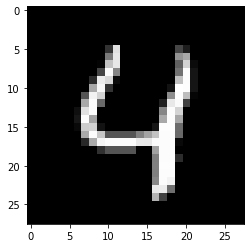

In [ ]:
# LRP를 수행할 이미지 하나를 부르는 과정

# show test image
idx = 4
imageToUse = mnist.test.images[idx]
plt.imshow(np.reshape(imageToUse,[28,28]), interpolation="nearest", cmap='gray')

In [ ]:
# 합성곱 신경망의 은닉 계층마다 활성화 함수를 구하는 코드

# layers = [hidden_1, pool_1, hidden_2, pool_2, hidden_3]
activations = []
for layer in layers:
    activations.append(getActivations(layer, imageToUse))


In [ ]:
# 합성곱 신경망에 이미지를 입력하고 out_y 예측 결과를 구하는 코드

predict = sess.run(out_y, feed_dict={x: imageToUse.reshape([-1, 784]), keep_prob:1.0})[0]
idx = 0
for i in predict:
    print('[{}] {:.2%}'.format(idx, i))
    idx += 1


[0] 0.06%
[1] 0.00%
[2] 0.52%
[3] 0.05%
[4] 91.26%
[5] 0.50%
[6] 1.97%
[7] 0.12%
[8] 0.25%
[9] 5.26%


In [ ]:
# 학습된 합성곱 신경망으로부터 분류 가능성이 최대가 되는 카테고리를 구하는 코드

f_x = max(predict)
print(f_x)

0.9126395


In [ ]:
# 완전 연결 신경망에서 역전파 기울기를 구하는 수도 코드

# get FC layer gradient
def getGradient(activation, weight, bias):
    # forward pass
    W = tf.maximum(0., weight)
    b = tf.maximum(0., bias)
    z = tf.matmul(activation, w) + b

    # backward pass
    dX = tf.matmul(1/z, tf.transpose(W))
    return dX


In [ ]:
#  f_x로부터 바로 직전 은닉층의 타당성 전파 값을 구하는 코드

R4 = predict
R4.shape

(10,)

In [ ]:
# FC 연결에서 LRP를 수행하는 코드. 예제 7.8의 역전파 기울기를 구하는 코드에 타당성 변수(relevance)를 곱한다

def backprop_dense(activation, weight, bias, relevance):
    w = tf.maximum(0., weight)
    b = tf.maximum(0., bias)
    z = tf.matmul(activation, w) + b
    s = relevance / z
    c = tf.matmul(s, tf.transpose(w))
    return activation * c


In [ ]:
# LRP 공식으로 𝑅3를 구하는 코드

# layers = [hidden_1, pool_1, hidden_2, pool_2, hidden_3]
# (1, 28, 28, 5) (1, 14, 14, 5) (1, 7, 7, 20)
# activation, weights, biases
a = activations.pop()
w = weights.pop()
b = biases.pop()

print(a.shape)
print(w.shape)

R3 = backprop_dense(a.reshape(1,980), w, b, R4)

print(R3.shape)


(1, 7, 7, 20)
(980, 10)
(1, 980)


In [ ]:
# 언풀링 연산에서 LRP를 구하는 코드

from tensorflow.python.ops import gen_nn_ops

def backprop_pooling(activation, relevance):
    # kernel size, strides
    # if z is zero
    ksize = strides = [1, 2, 2, 1]
    z = tf.nn.max_pool(activation, ksize, strides, padding='SAME') + 1e-10
    s = relevance / z
    # input, argmax, argmax_mask
    c = gen_nn_ops.max_pool_grad(activation, z, s, ksize, strides, padding='SAME')
    return activation * c


In [ ]:
# 역합성곱 연산에서 LRP를 구하는 코드

def backprop_conv(activation, weight, bias, relevance):
    strides = [1, 1, 1, 1]
    w = tf.maximum(0., weight)
    b = tf.maximum(0., bias)
    z = tf.nn.conv2d(activation, w, strides, padding='SAME')
    z = tf.nn.bias_add(z, b)
    s = relevance / z
    c = tf.nn.conv2d_backprop_input(tf.shape(activation), w, s, strides, padding='SAME')
    return activation * c


In [ ]:
# 𝑅3 벡터로부터 역합성곱과 언풀링 연산을 수행하고 𝑅2 벡터를 구하는 코드

# layers = [hidden_1, pool_1, hidden_2, pool_2]
# (1, 28, 28, 5)(1, 14, 14, 5)(1, 7, 7, 20)
# activation, weights, biases
w = weights.pop()
b = biases.pop()
p = activations.pop()
a = activations.pop()
print(p.shape)

# convolution backprop
R_conv = backprop_conv(p, w, b, tf.reshape(R3, [1, 7, 7, 20]))
print(R_conv.shape)
R2 = backprop_pooling(a, R_conv)
print(R2.shape)

(1, 7, 7, 5)
(1, 7, 7, 5)
(1, 14, 14, 5)


In [ ]:
# 𝑅2에서 역합성곱과 언풀링 과정을 수행하고 𝑅1 벡터를 구하는 코드

# layers = [hidden_1, pool_1]
# (1, 28, 28, 5)(1, 14, 14, 5)
# activation, weights, biases
w = weights.pop()
b = biases.pop()
p = activations.pop()
a = activations.pop()

# convolution backprop
R_conv = backprop_conv(p, w, b, R2)
print(R_conv.shape)

R1 = backprop_pooling(a, R_conv)
print(R1.shape)
print(np.sum(sess.run(R1)))


(1, 14, 14, 5)
(1, 28, 28, 5)
0.9866709


In [ ]:
# 𝑅1 결과에서 원본 이미지까지 LRP를 수행하는 코드

img_activations = getActivations(x_image, imageToUse)
w = weights.pop()
b = biases.pop()
R0 = backprop_conv(img_activations, w, b, R1)
LRP_out = sess.run(R0)

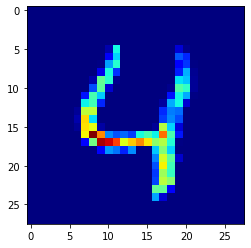

In [ ]:
# 원본 이미지 형태로 타당성 전파를 수행하고 결과물을 이미지 형태로 출력하는 코드

plt.imshow(LRP_out.reshape(28, 28), interpolation="nearest", cmap=plt.cm.jet)

In [ ]:
# 합성곱 신경망 전체에 대해 LRP를 수행하는 코드

def getLRP(img):
    predict = sess.run(out_y, feed_dict={x: img.reshape([-1, 784]), keep_prob:1.0})[0]
    layers = [hidden_1, pool_1, hidden_2, pool_2, hidden_3]
    weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='.*weights.*')
    biases = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='.*biases.*')

    # layers = [hidden_1, pool_1, hidden_2, pool_2, hidden_3]
    activations = []
    for layer in layers:
        activations.append(getActivations(layer, img))

    # get f_x
    f_x = max(predict)

    # get R4
    predict[predict < 0] = 0
    R4 = predict

    # get R3
    a = activations.pop()
    w = weights.pop()
    b = biases.pop()
    R3 = backprop_dense(a.reshape(1,980), w, b, R4)

    # get R2
    w = weights.pop()
    b = biases.pop()
    p = activations.pop()
    a = activations.pop()
    R_conv = backprop_conv(p, w, b, tf.reshape(R3, [1, 7, 7, 20]))
    R2 = backprop_pooling(a, R_conv)

    # get R1
    w = weights.pop()
    b = biases.pop()
    p = activations.pop()
    a = activations.pop()
    R_conv = backprop_conv(p, w, b, R2)
    R1 = backprop_pooling(a, R_conv)

    # get R0
    img_activations = getActivations(x_image, img)
    w = weights.pop()
    b = biases.pop()
    R0 = backprop_conv(img_activations, w, b, R1)
    LRP_out = sess.run(R0)
    return LRP_out


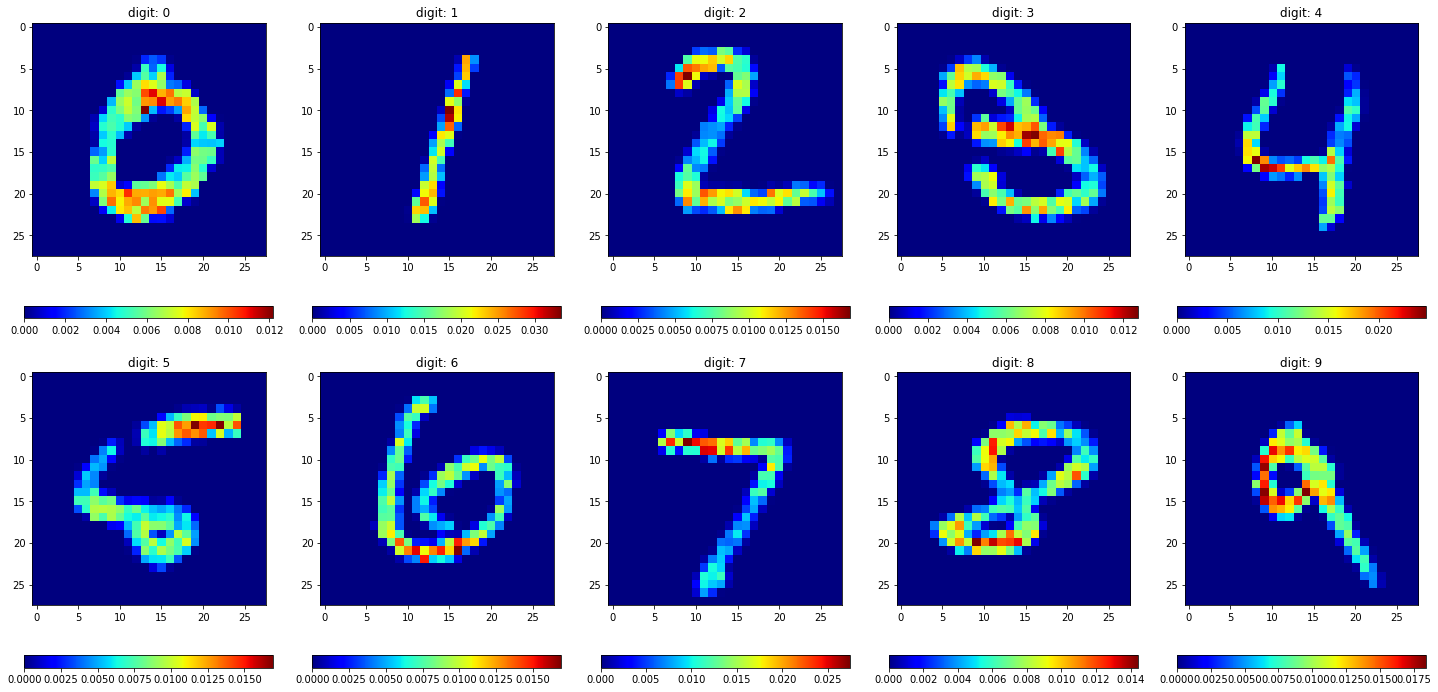

In [ ]:
# 합성곱 신경망 전체에 대해 LRP를 수행하는 코드

# get MNIST dataset index dict
mnist_dict = {}
idx = 0
for i in mnist.test.labels:
    label = np.where(i == np.amax(i))[0][0]
    if mnist_dict.get(label):
        mnist_dict[label].append(idx)
    else:
        mnist_dict[label] = [idx]
    idx += 1

# get LRP
nums = []
for i in range(10):
    img_idx = mnist_dict[i][0]
    img = mnist.test.images[img_idx]
    lrp = getLRP(img)
    nums.append(lrp)

# plot images
plt.figure(figsize=(20,10))
for i in range(2):
    for j in range(5):
        idx = 5 * i + j
        plt.subplot(2, 5, idx + 1)
        plt.title('digit: {}'.format(idx))
        plt.imshow(nums[idx].reshape([28, 28]), cmap=plt.cm.jet)
        plt.colorbar(orientation='horizontal')
plt.tight_layout()
sess.close()
